This script takes the harvard-oxford cortical and subcortical atlases as parcellations and pulls mean betas for each subject for each roi

Author: Paul A. Bloom

Date: November 21, 2018

In [2]:
import nilearn
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import glob

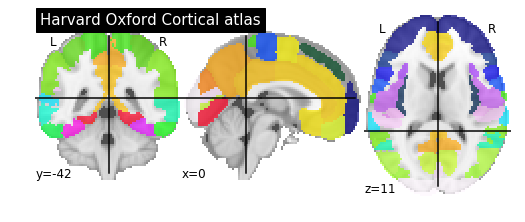

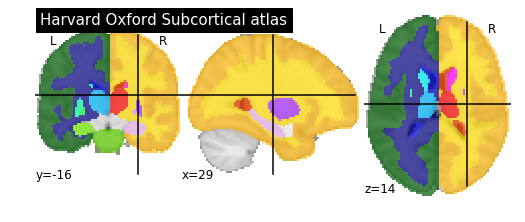

In [3]:
# Define parcellation paths and plot them
hoCorticalPath = '/usr/local/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz'
hoCortical = image.load_img(hoCorticalPath)
hoSubcorticalPath = '/usr/local/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-2mm.nii.gz'
hoSubcortical = image.load_img(hoSubcorticalPath)
plotting.plot_roi(hoCortical, title="Harvard Oxford Cortical atlas")
plotting.plot_roi(hoSubcortical, title="Harvard Oxford Subcortical atlas")

In [4]:
# Loop through cortical ROIs to make masks using fslmaths
for i in range(1,49):
    lower = i - 0.1
    upper = i + 0.1
    
    message = 'fslmaths %s -thr %s -uthr %s -bin ../roi/harvardox_cortical_%s.nii.gz'%(hoCorticalPath, lower, upper, i)
    os.system(message)

In [5]:
# Loop through subcortical ROIs to make masks using fslmaths
for i in range(1,22):
    lower = i - 0.1
    upper = i + 0.1
    
    message = 'fslmaths %s -thr %s -uthr %s -bin ../roi/harvardox_subcortical_%s.nii.gz'%(hoSubcorticalPath, lower, upper, i)
    os.system(message)

In [6]:
# read in frame of subjects
subFrame = pd.read_csv('/danl/SB/PaulCompileTGNG/mri_scripts/6_neuropointillist/subFrameAll.csv')


In [7]:
# Define a function to pull the mean beta for a given ROI for a given subject
def getMeanBeta(subject, roi):
    mask = image.load_img(roi)
    maskDat = mask.get_fdata()
    maskDat = maskDat.flatten()

    fearCope = image.load_img('/danl/SB/PaulCompileTGNG/data/%s/model/fearNeutModel/6motion_no_errors.feat/reg_standard/stats/cope1.nii.gz'%(subject))
    fearCope = fearCope.get_fdata()
    fearCope = fearCope.flatten()
            
    maskedCope = fearCope[maskDat == 1]
    meanCope = np.mean(maskedCope) 
    return(meanCope)

In [8]:
# Compile list of ROIs and name columns accordingly
roiList = glob.glob('../roi/*.nii.gz')
for ii, region in enumerate(roiList):
	regionName = region[7:][:-7]
	subFrame[regionName] = np.nan


In [9]:
# Loop through each region for each subject and pull mean betas into a dataframe
regionColumns = list(subFrame)[6:]

for index, row in subFrame.iterrows():
    if(os.path.isfile('/danl/SB/PaulCompileTGNG/data/%s/model/fearNeutModel/6motion_no_errors.feat/reg_standard/stats/cope1.nii.gz'%(row['name']))):
        for columnName in list(regionColumns):
            roiPath = '../roi/' + columnName + '.nii.gz'
            subFrame[columnName][index] = getMeanBeta(row['name'], roiPath)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
# Drop extra columns, inspect, and output to csv
meansFrame = subFrame.drop(['Age', 'group','name'], axis = 1)
meansFrame.head()
meansFrame.to_csv('../harvard_ox_means.csv', index = False)